In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import statsmodels.graphics.tsaplots as sgt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

In [2]:
train = pd.read_csv('C:/Users/MARIA PAULA/Downloads/EAFIT/Proyecto de Grado/Programacion/Dataset_definitivos/Train.csv')
val = pd.read_csv('C:/Users/MARIA PAULA/Downloads/EAFIT/Proyecto de Grado/Programacion/Dataset_definitivos/Val.csv')

In [3]:
# train['Fecha Trafico'] = pd.to_datetime(train['Fecha Trafico'])
# val['Fecha Trafico'] = pd.to_datetime(val['Fecha Trafico'])

In [4]:
train = train.drop(['timestamp','Fecha Trafico'], axis = 1)
val = val.drop(['timestamp','Fecha Trafico'], axis = 1)

In [5]:
train.columns

Index(['codigo comuna', 'corredor_enc', 'sentido_enc', 'f_pm_25',
       'Velocidad (Km/h)', 'Intensidad', 'Nº vehiculos long 1',
       'Nº vehiculos long 2', 'Nº vehiculos long 3', 'operacion_enc',
       'f_pm_25_lag_1_h', 'f_pm_25_lag_2_h', 'f_pm_25_lag_3_h',
       'f_sma_3_pm_25', 'f_sd_3_pm_25', 'f_sum_3_pm_25',
       'f_calendar_day_of_month', 'f_calendar_day_of_week', 'f_calendar_month',
       'pm_25', 'label_horizon_1_hours', 'label_horizon_2_hours'],
      dtype='object')

Al haber usado rezagos pierdo informacion en las primeras fechas donde no hay rezagos, por lo que recorto la info para no tomar nulos y poder entrenar 

In [6]:
def missing_values(df):
    Column_Names = df.columns

    Total_rows = df.shape[0]

    missing_values = df.isnull().sum()

    Percent_missing = (missing_values / Total_rows)*100
    
    result = pd.DataFrame({
        'Column_Name': Column_Names,
        'Missing_Values': missing_values.values,
        'Total_Rows': Total_rows,
        'Percent_Missing': Percent_missing.values
    })

    return result

In [7]:
nulos = missing_values(train)
nulos.sort_values(by ='Missing_Values', ascending = False)

,Column_Name,Missing_Values,Total_Rows,Percent_Missing
12,f_pm_25_lag_3_h,288,84484,0.340893
11,f_pm_25_lag_2_h,192,84484,0.227262
10,f_pm_25_lag_1_h,96,84484,0.113631
14,f_sd_3_pm_25,1,84484,0.001184
0,codigo comuna,0,84484,0.000000
1,corredor_enc,0,84484,0.000000
5,Intensidad,0,84484,0.000000
4,Velocidad (Km/h),0,84484,0.000000
3,f_pm_25,0,84484,0.000000
2,sentido_enc,0,84484,0.000000


In [8]:
train.dtypes

codigo comuna              float64
corredor_enc               float64
sentido_enc                float64
f_pm_25                    float64
Velocidad (Km/h)           float64
Intensidad                 float64
Nº vehiculos long 1        float64
Nº vehiculos long 2        float64
Nº vehiculos long 3        float64
operacion_enc                int64
f_pm_25_lag_1_h            float64
f_pm_25_lag_2_h            float64
f_pm_25_lag_3_h            float64
f_sma_3_pm_25              float64
f_sd_3_pm_25               float64
f_sum_3_pm_25              float64
f_calendar_day_of_month      int64
f_calendar_day_of_week       int64
f_calendar_month             int64
pm_25                      float64
label_horizon_1_hours      float64
label_horizon_2_hours      float64
dtype: object

In [9]:
def plot_acf_pacf(series, lags=72, alpha=0.05):
    plt.rcParams["figure.figsize"] = 25, 15
    
    # Calcula el intervalo de confianza
    n = len(series)
    conf_interval = 1.96 / np.sqrt(n)  # Nivel de confianza al 95%

    fig, axes = plt.subplots(2, 1)

    # ACF con intervalo de confianza
    acf_plot = plot_acf(series, zero=False, lags=lags, ax=axes[0], alpha=alpha)
    axes[0].axhline(y=conf_interval, linestyle="--", color="red", label="Conf. Interval")
    axes[0].axhline(y=-conf_interval, linestyle="--", color="red")
    axes[0].set_title("ACF")
    axes[0].legend()

    # PACF con intervalo de confianza
    pacf_plot = plot_pacf(series, zero=False, lags=lags, ax=axes[1], alpha=alpha)
    axes[1].axhline(y=conf_interval, linestyle="--", color="red", label="Conf. Interval")
    axes[1].axhline(y=-conf_interval, linestyle="--", color="red")
    axes[1].set_title("PACF")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

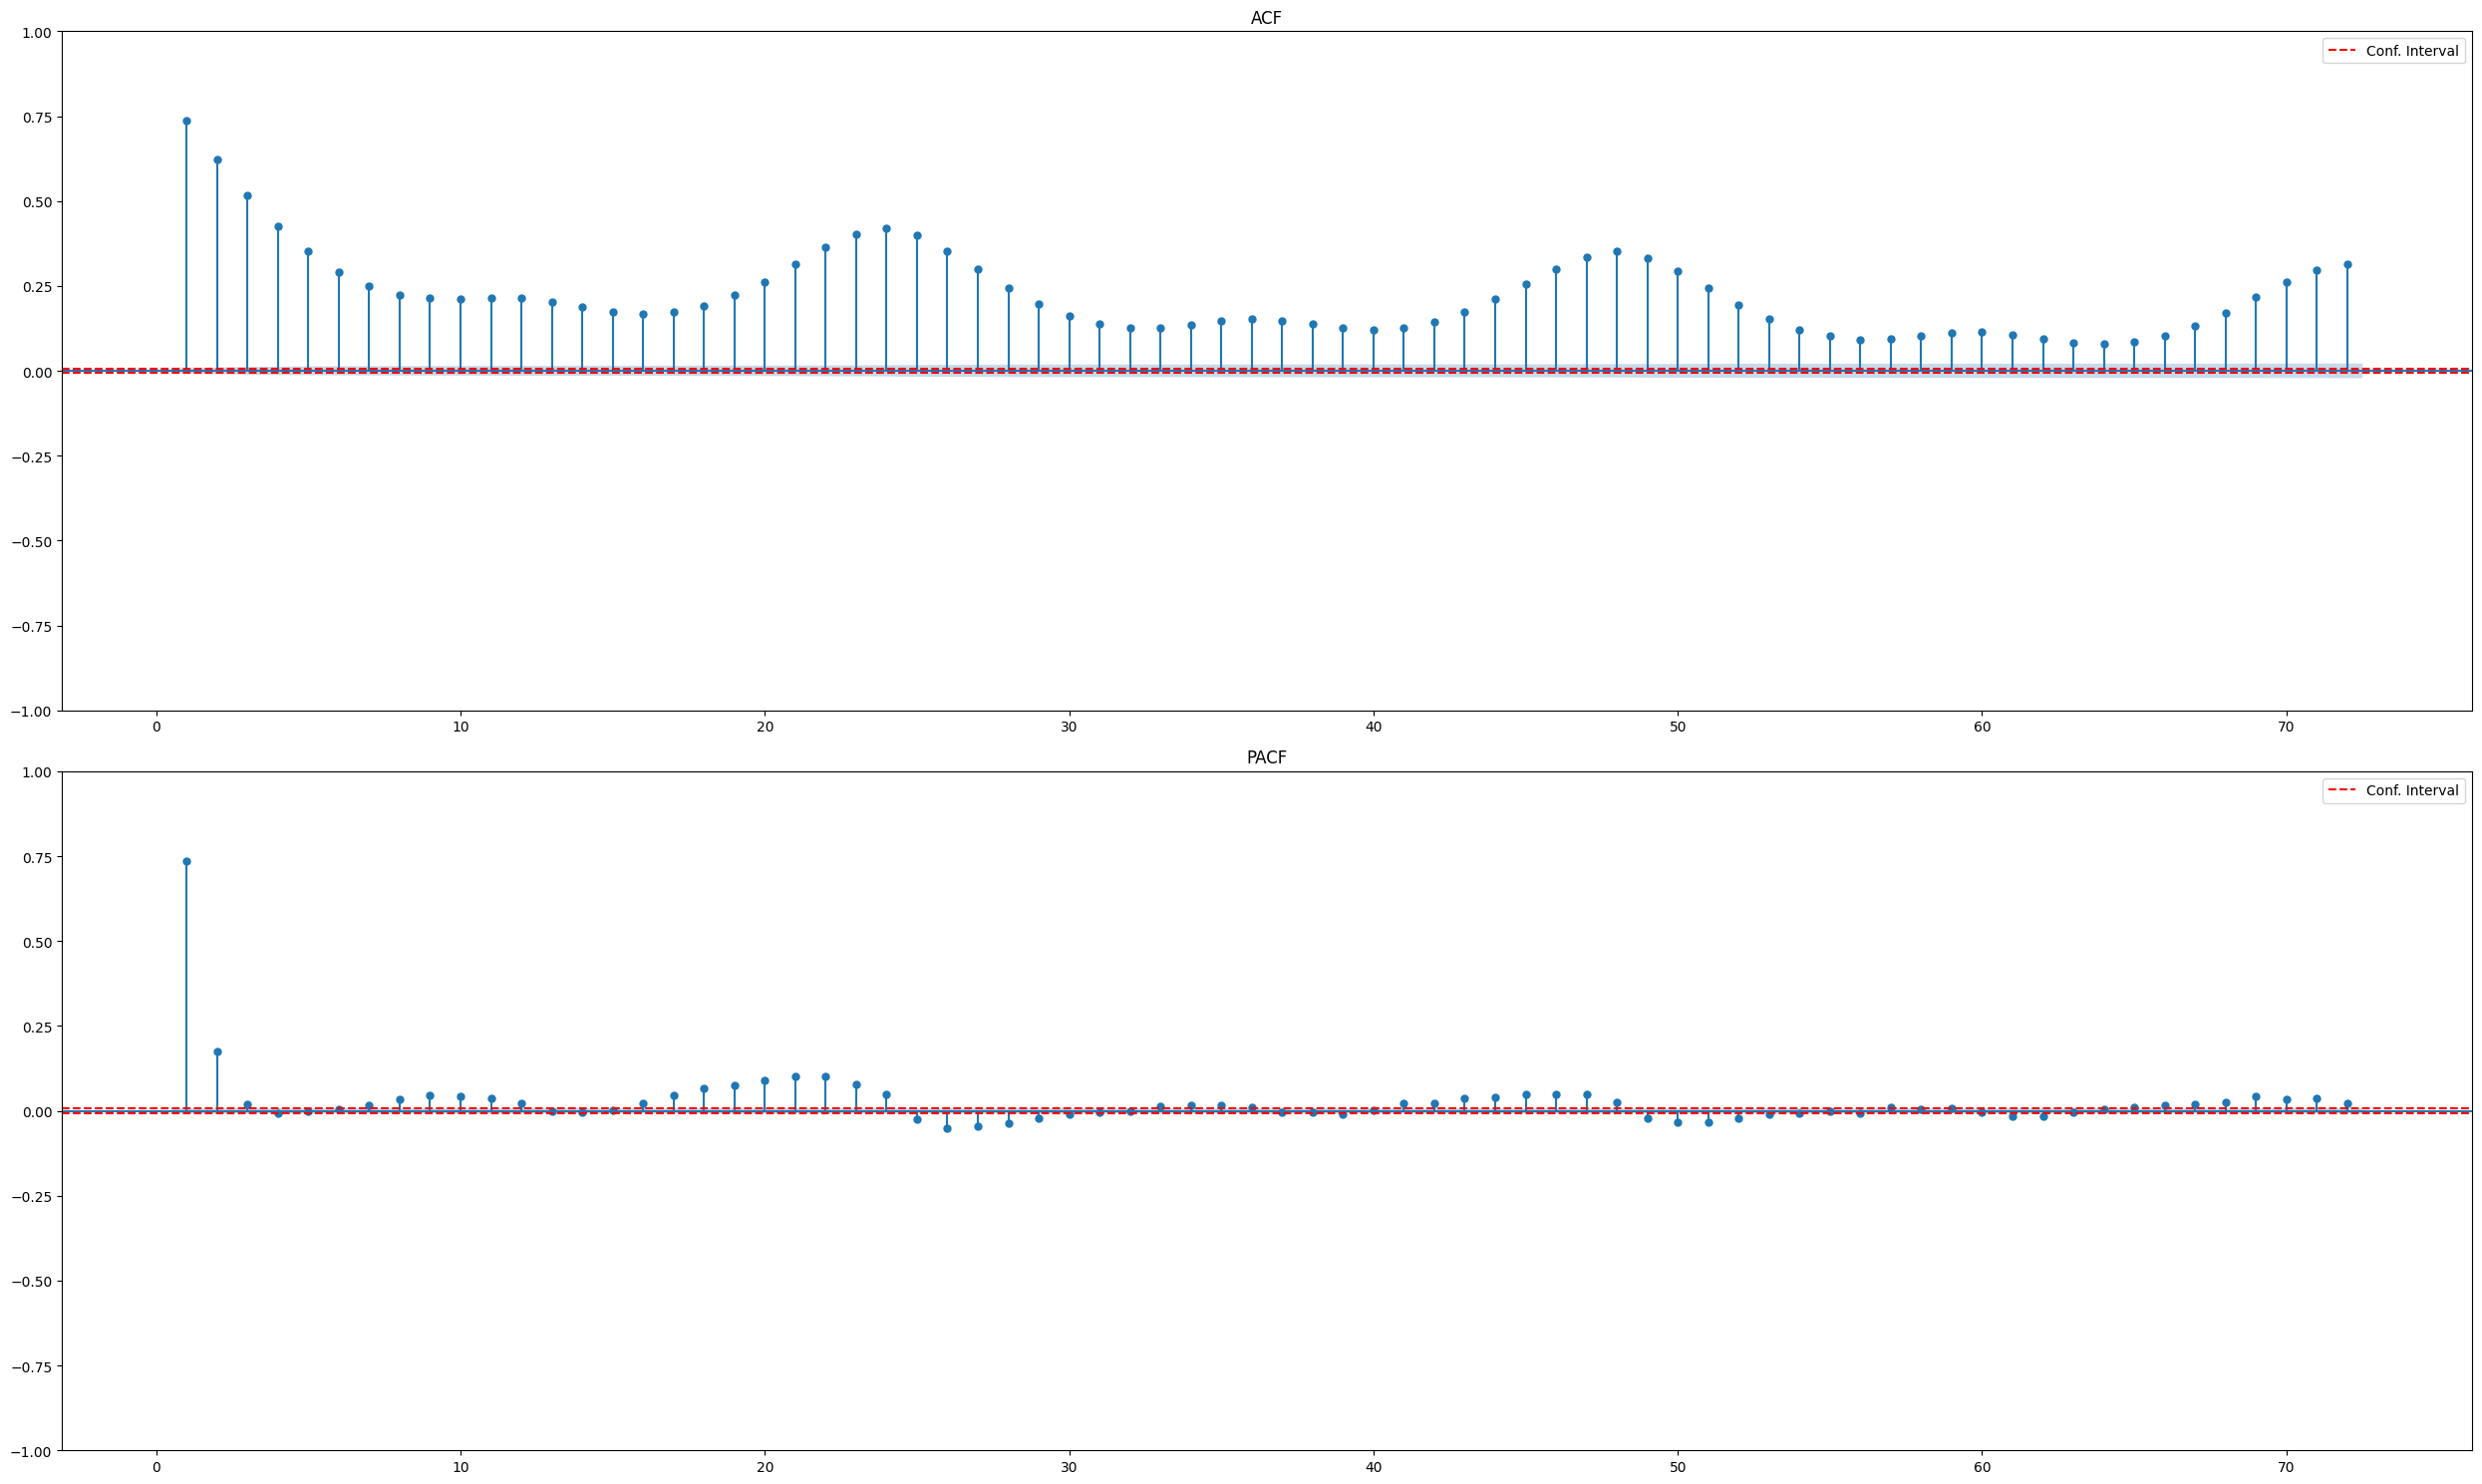

In [10]:
plot_acf_pacf(train['pm_25'])

* Gráfica de ACF:

Muestra una disminución gradual y persistente de la autocorrelación.
Esto podría indicar la presencia de componentes estacionales o tendencias a largo plazo en los datos.

* Gráfica de PACF:

Presenta una caída rápida después del primer lag y un comportamiento con valores muy pequeños para los lags subsiguientes, dentro del intervalo de confianza.

--------------------------------------------------
--------------------------------------------------
Los primeros valores (1 a 3 lags) parecen ser los más significativos, ya que se encuentran claramente fuera del intervalo de confianza en ambas gráficas.
A partir del lag 4 o 5, los valores de PACF están dentro del intervalo de confianza, lo que indica que no contribuyen significativamente a explicar la serie después de remover la correlación con los lags intermedios.

In [11]:
result = adfuller(train['pm_25'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")

ADF Statistic: -21.126839486813882
p-value: 0.0
Critical Values: {'1%': np.float64(-3.430427465692802), '5%': np.float64(-2.861574238552925), '10%': np.float64(-2.56678822399577)}
The series is stationary.


# Entrenamiento del modelo

In [12]:
missing_values(train).sort_values(by = 'Missing_Values', ascending= True)

,Column_Name,Missing_Values,Total_Rows,Percent_Missing
0,codigo comuna,0,84484,0.000000
1,corredor_enc,0,84484,0.000000
2,sentido_enc,0,84484,0.000000
3,f_pm_25,0,84484,0.000000
4,Velocidad (Km/h),0,84484,0.000000
5,Intensidad,0,84484,0.000000
6,Nº vehiculos long 1,0,84484,0.000000
7,Nº vehiculos long 2,0,84484,0.000000
8,Nº vehiculos long 3,0,84484,0.000000
9,operacion_enc,0,84484,0.000000


In [13]:
train = train.dropna()

In [14]:
missing_values(train)

,Column_Name,Missing_Values,Total_Rows,Percent_Missing
0,codigo comuna,0,84196,0.0
1,corredor_enc,0,84196,0.0
2,sentido_enc,0,84196,0.0
3,f_pm_25,0,84196,0.0
4,Velocidad (Km/h),0,84196,0.0
5,Intensidad,0,84196,0.0
6,Nº vehiculos long 1,0,84196,0.0
7,Nº vehiculos long 2,0,84196,0.0
8,Nº vehiculos long 3,0,84196,0.0
9,operacion_enc,0,84196,0.0


In [15]:
def separar_target(df): 
    X = df.drop(['pm_25'], axis=1)
    y = df['pm_25']
    return X, y

In [19]:
X_train, y_train = separar_target(train)
X_val, y_val = separar_target(val)

In [20]:
def entrenamiento_con_validacion_temporal(model, X_train, y_train, X_test, y_test, n_splits=3):
    """
    Entrena un modelo y lo evalúa utilizando validación temporal, ajustando el conjunto de entrenamiento
    en cada iteración para evaluar cómo cambian las métricas.

    Parameters:
    model: El modelo de machine learning que se va a entrenar.
    X_train: DataFrame o array con las características del conjunto de entrenamiento.
    y_train: Serie o array con las etiquetas del conjunto de entrenamiento.
    X_test: DataFrame o array con las características del conjunto de prueba.
    y_test: Serie o array con las etiquetas del conjunto de prueba.
    n_splits: Número de divisiones para la validación temporal.

    Returns:
    model: El modelo entrenado.
    metrics: Diccionario con métricas de evaluación (RMSE, R^2 y MAE).
    """
    # Crear validación temporal
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print("\nResultados de Validación Temporal para cada iteración:")
    fold = 1
    temporal_rmse = []
    temporal_r2 = []
    temporal_mae = []

    for train_index, val_index in tscv.split(X_train):
        # Utilizar iloc para acceder a las filas correspondientes
        X_t_train = X_train.iloc[train_index]  # Entrenamiento
        y_t_train = y_train.iloc[train_index]
        X_t_val = X_train.iloc[val_index]     # Validación
        y_t_val = y_train.iloc[val_index]

        # Entrenar el modelo con el conjunto de entrenamiento ajustado
        model.fit(X_t_train, y_t_train)

        # Predicciones en el conjunto de validación
        y_val_pred = model.predict(X_t_val)

        # Calcular métricas en el conjunto de validación
        rmse = root_mean_squared_error(y_t_val, y_val_pred)
        r2 = r2_score(y_t_val, y_val_pred)
        mae = mean_absolute_error(y_t_val, y_val_pred)

        temporal_rmse.append(rmse)
        temporal_r2.append(r2)
        temporal_mae.append(mae)

        print(f"Iteración {fold}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R^2: {r2:.4f}")
        print(f"  MAE: {mae:.4f}")
        fold += 1

    # Promedio de métricas de validación temporal
    avg_rmse = np.mean(temporal_rmse)
    avg_r2 = np.mean(temporal_r2)
    avg_mae = np.mean(temporal_mae)

    print("\nPromedio de Métricas de Validación Temporal:")
    print(f"  Promedio RMSE: {avg_rmse:.4f}")
    print(f"  Promedio R^2: {avg_r2:.4f}")
    print(f"  Promedio MAE: {avg_mae:.4f}")

    # Evaluar en el conjunto de prueba final
    model.fit(X_train, y_train)  # Entrenar con todo el conjunto de entrenamiento original
    y_test_pred = model.predict(X_test)

    final_rmse = root_mean_squared_error(y_test, y_test_pred)
    final_r2 = r2_score(y_test, y_test_pred)
    final_mae = mean_absolute_error(y_test, y_test_pred)

    print("\nEvaluación en el Conjunto de Prueba Final:")
    print(f"  RMSE: {final_rmse:.4f}")
    print(f"  R^2 Score: {final_r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {final_mae:.4f}")

    # Devolver el modelo y las métricas
    metrics = {
        'Temporal_RMSE': avg_rmse,
        'Temporal_R2': avg_r2,
        'Temporal_MAE': avg_mae,
        'Test_RMSE': final_rmse,
        'Test_R2': final_r2,
        'Test_MAE': final_mae
    }

    return model, metrics


In [21]:
# Primero, eliminar las columnas de mobilidad de df_train
train_reduced_base = train.drop(['f_pm_25','codigo comuna', 'corredor_enc', 'sentido_enc', 'Velocidad (Km/h)', 'Intensidad', 
                                 'Nº vehiculos long 1','Nº vehiculos long 2', 'Nº vehiculos long 3', 'operacion_enc', 'label_horizon_1_hours', 'label_horizon_2_hours'],axis=1)

# Luego, asegúrate de que val tenga las mismas columnas
val_reduced_base = val.drop(['f_pm_25','codigo comuna', 'corredor_enc', 'sentido_enc', 'Velocidad (Km/h)', 'Intensidad', 
                                 'Nº vehiculos long 1','Nº vehiculos long 2', 'Nº vehiculos long 3', 'operacion_enc', 'label_horizon_1_hours', 'label_horizon_2_hours'],axis=1)

X_train_base, y_train_base = separar_target(train_reduced_base)
X_val_base, y_val_base = separar_target(val_reduced_base)



## Dataset Serie de tiempo sin vbles de mobilidad

In [22]:
# Modelos a entrenar
modelo_lr_base = LinearRegression()
modelo_rf_base = RandomForestRegressor(random_state=42)
modelo_xgb_base = XGBRegressor(random_state=42)

# Entrenar y evaluar Linear Regression
print("Entrenando Linear Regression:")
modelo_lr_entrenado_base, metrics_lr_base = entrenamiento_con_validacion_temporal(model=modelo_lr_base, X_train=X_train_base, y_train=y_train_base, X_test=X_val_base, y_test=y_val_base)

# Entrenar y evaluar Random Forest
print("\nEntrenando Random Forest:")
modelo_rf_entrenado_base, metrics_rf_base = entrenamiento_con_validacion_temporal(modelo_rf_base, X_train_base, y_train_base, X_val_base, y_val_base)

# Entrenar y evaluar XGBoost
print("\nEntrenando XGBoost:")
modelo_xgb_entrenado_base, metrics_xgb_base = entrenamiento_con_validacion_temporal(modelo_xgb_base, X_train_base, y_train_base, X_val_base, y_val_base)

Entrenando Linear Regression:

Resultados de Validación Temporal para cada iteración:
Iteración 1:
  RMSE: 6.6875
  R^2: 0.2380
  MAE: 5.1784
Iteración 2:
  RMSE: 6.9312
  R^2: 0.2601
  MAE: 5.3145
Iteración 3:
  RMSE: 10.4046
  R^2: 0.1783
  MAE: 8.1046

Promedio de Métricas de Validación Temporal:
  Promedio RMSE: 8.0078
  Promedio R^2: 0.2255
  Promedio MAE: 6.1992

Evaluación en el Conjunto de Prueba Final:
  RMSE: 6.7126
  R^2 Score: 0.2172
  Mean Absolute Error (MAE): 5.1509

Entrenando Random Forest:

Resultados de Validación Temporal para cada iteración:
Iteración 1:
  RMSE: 6.8154
  R^2: 0.2086
  MAE: 5.2823
Iteración 2:
  RMSE: 6.8632
  R^2: 0.2745
  MAE: 5.3067
Iteración 3:
  RMSE: 10.6878
  R^2: 0.1329
  MAE: 8.4056

Promedio de Métricas de Validación Temporal:
  Promedio RMSE: 8.1221
  Promedio R^2: 0.2053
  Promedio MAE: 6.3315

Evaluación en el Conjunto de Prueba Final:
  RMSE: 6.7526
  R^2 Score: 0.2079
  Mean Absolute Error (MAE): 5.1667

Entrenando XGBoost:

Resultado

In [23]:
X_train, y_train = separar_target(train)
X_val, y_val = separar_target(val)

X_train = X_train.drop(['f_pm_25','label_horizon_1_hours', 'label_horizon_2_hours'],axis=1)
X_val = X_val.drop(['f_pm_25', 'label_horizon_1_hours', 'label_horizon_2_hours'],axis=1)

## Dataset Serie de tiempo con mobilidad

In [24]:
# Modelos a entrenar
modelo_lr = LinearRegression()
modelo_rf = RandomForestRegressor(random_state=42)
modelo_xgb = XGBRegressor(random_state=42)

# # Entrenar y evaluar Linear Regression
print("Entrenando Linear Regression:")
modelo_lr_entrenado, metrics_lr = entrenamiento_con_validacion_temporal(model=modelo_lr, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val)

# Entrenar y evaluar Random Forest
print("\nEntrenando Random Forest:")
modelo_rf_entrenado, metrics_rf = entrenamiento_con_validacion_temporal(model=modelo_rf, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val)

# Entrenar y evaluar XGBoost
print("\nEntrenando XGBoost:")
modelo_xgb_entrenado, metrics_xgb = entrenamiento_con_validacion_temporal(model=modelo_xgb, X_train=X_train, y_train=y_train, X_test=X_val, y_test=y_val)


Entrenando Linear Regression:

Resultados de Validación Temporal para cada iteración:
Iteración 1:
  RMSE: 6.6983
  R^2: 0.2355
  MAE: 5.1825
Iteración 2:
  RMSE: 7.3222
  R^2: 0.1743
  MAE: 5.5645
Iteración 3:
  RMSE: 10.6426
  R^2: 0.1402
  MAE: 8.1935

Promedio de Métricas de Validación Temporal:
  Promedio RMSE: 8.2210
  Promedio R^2: 0.1834
  Promedio MAE: 6.3135

Evaluación en el Conjunto de Prueba Final:
  RMSE: 6.7089
  R^2 Score: 0.2181
  Mean Absolute Error (MAE): 5.1548

Entrenando Random Forest:

Resultados de Validación Temporal para cada iteración:
Iteración 1:
  RMSE: 7.5113
  R^2: 0.0387
  MAE: 5.7540
Iteración 2:
  RMSE: 7.3552
  R^2: 0.1668
  MAE: 5.7391
Iteración 3:
  RMSE: 10.7068
  R^2: 0.1298
  MAE: 8.3565

Promedio de Métricas de Validación Temporal:
  Promedio RMSE: 8.5244
  Promedio R^2: 0.1118
  Promedio MAE: 6.6165

Evaluación en el Conjunto de Prueba Final:
  RMSE: 6.6026
  R^2 Score: 0.2427
  Mean Absolute Error (MAE): 5.0945

Entrenando XGBoost:

Resultado

| Modelo sin mov         | RMSE   | MAE    | R^2    |
|--------------------|--------|--------|--------|
| CV Temp  | 8.1783 | 6.3374 | 0.1947 |
| Test | 6.7445 | 5.1274 | 0.2098 |


\

| Modelo con mov             | RMSE   | MAE    | R^2 |
|--------------------|--------|--------|--------|
| CV Temp   | 9.1583 | 7.0633 | -0.0441 |
| Test   | 6.4890 | 4.9722 | 0.2686 |


In [25]:
importanceRF_base = modelo_rf_entrenado_base.feature_importances_
importanceXGB_base = modelo_xgb_entrenado_base.feature_importances_

importanceRF = modelo_rf_entrenado.feature_importances_
importanceXGB = modelo_xgb_entrenado.feature_importances_

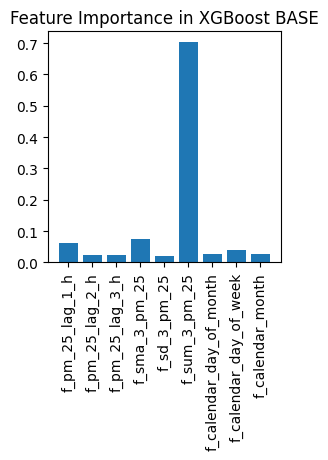

In [26]:
plt.figure(figsize=(3,3))
plt.bar(range(X_train_base.shape[1]), importanceXGB_base)
plt.xticks(range(X_train_base.shape[1]), X_train_base.columns, rotation=90)
plt.title("Feature Importance in XGBoost BASE")
plt.show()

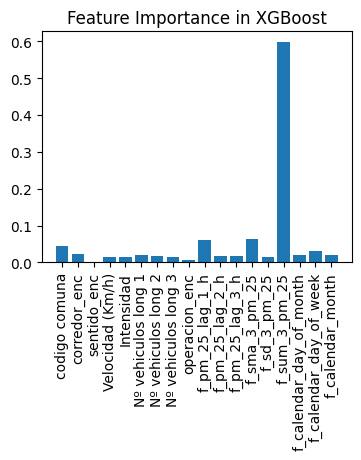

In [27]:
plt.figure(figsize=(4,3))
plt.bar(range(X_train.shape[1]), importanceXGB)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.title("Feature Importance in XGBoost")
plt.show()

# Optimizacion de hiperparametros

In [29]:
# Configura TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Definir el modelo
# xgboost sin movilidad
model = modelo_xgb_base

# Configurar los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'gamma': [None, 0, 0.1, 0.5, 1]
}

# GridSearch con TimeSeriesSplit
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)


Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Mejores hiperparámetros: {'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


# Entrenamiento final con prediccion conformal

In [40]:
test = pd.read_csv('C:/Users/MARIA PAULA/Downloads/EAFIT/Proyecto de Grado/Programacion/Dataset_definitivos/test.csv')

In [41]:
test = test.drop(['timestamp','Fecha Trafico'], axis = 1)

# Primero, eliminar las columnas de mobilidad de test
test_reduced_base = test.drop(['f_pm_25','codigo comuna', 'corredor_enc', 'sentido_enc', 'Velocidad (Km/h)', 'Intensidad', 
                                 'Nº vehiculos long 1','Nº vehiculos long 2', 'Nº vehiculos long 3', 'operacion_enc', 'label_horizon_1_hours', 'label_horizon_2_hours'],axis=1)


X_test_b, y_test_b = separar_target(test_reduced_base)

In [46]:
# Entrenar el modelo final en el conjunto de entrenamiento
final_model = XGBRegressor(**grid_search.best_params_, random_state=42)
final_model.fit(X_train_base, y_train_base)

# Calcular predicciones en el conjunto de validación (calibración)
y_cal_pred = final_model.predict(X_val_base)

# Calcular residuos absolutos en calibración
residuals = np.abs(y_val_base - y_cal_pred)

# Estimar el percentil deseado (nivel de confianza 95%)
alpha = 0.05
q = np.quantile(residuals, 1 - alpha)

# Predicciones en el conjunto de prueba
y_test_pred = final_model.predict(X_test_b)

# Construir los intervalos de predicción
lower_bound = y_test_pred - q
upper_bound = y_test_pred + q

# Evaluar los intervalos de predicción en el conjunto de prueba
coverage = np.mean((y_test_b >= lower_bound) & (y_test_b <= upper_bound)) * 100

print("Cobertura del intervalo de predicción:", coverage, "%")

# Mostrar los resultados
import pandas as pd
results = pd.DataFrame({
    "y_real": y_test_b,
    "y_pred": y_test_pred,
    "lower_bound": lower_bound,
    "upper_bound": upper_bound
})

print(results.head())

Cobertura del intervalo de predicción: 90.03026227303296 %
    y_real     y_pred  lower_bound  upper_bound
0  16.5702  15.293157     2.079974    28.506339
1  14.1932  14.897474     1.684292    28.110657
2  16.5200  15.228119     2.014936    28.441301
3  20.0582  15.302389     2.089207    28.515572
4  16.4967  17.358339     4.145157    30.571522


In [57]:
# Cálculos de métricas
rmse = root_mean_squared_error(y_test_b, y_test_pred)
mae = mean_absolute_error(y_test_b, y_test_pred)
r2 = r2_score(y_test_b, y_test_pred)

# Mostrar las métricas
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 8.1514
MAE: 6.3063
R²: 0.2334


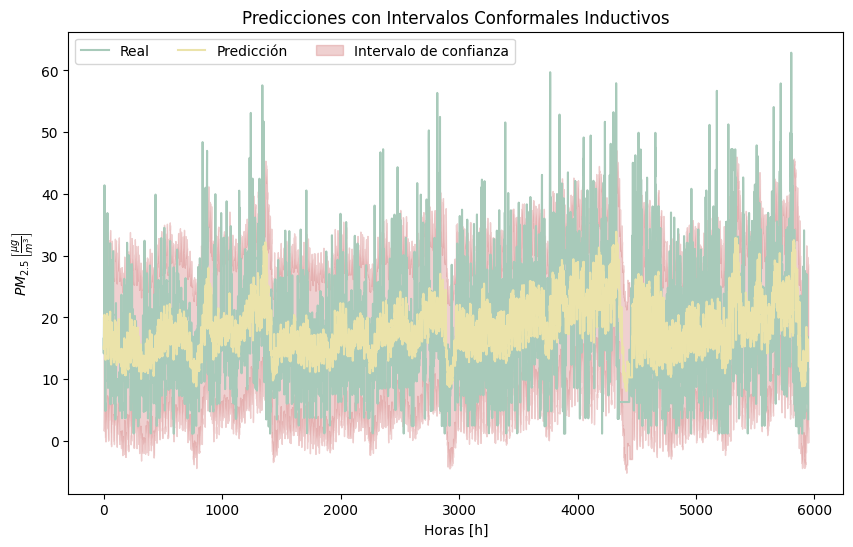

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_b.values, label="Real", color="#a8caba")
plt.plot(y_test_pred, label="Predicción", color="#ebe3aa")
plt.fill_between(range(len(y_test_b)), lower_bound, upper_bound, color="#cc6666", alpha=0.3, label="Intervalo de confianza")
plt.legend(ncol = 3)
plt.title("Predicciones con Intervalos Conformales Inductivos")
plt.xlabel('Horas [h]')
plt.ylabel(r'$PM_{2.5} \, \left[\frac{\mu g}{m^3}\right]$')
plt.show()


Línea de valores reales (y_test):

La línea verde representa los valores reales de la variable dependiente (en este caso, PM₂.₅). Estos son los valores que tu modelo intenta predecir.
La variabilidad en esta línea refleja la fluctuación natural de la variable que estás modelando, por ejemplo, fluctuaciones horarias o estacionales en la concentración de partículas PM₂.₅.


Línea de predicciones (y_test_pred):

La línea amarilla representa las predicciones hechas por el modelo para los datos de prueba.
Cuanto más cerca esté la línea de predicción de la línea de valores reales, mejor será el rendimiento del modelo.


Intervalos de confianza (área gris):

La zona sombreada en roja muestra el intervalo de predicción para cada punto, con un nivel de confianza especificado (por ejemplo, 95%).
Interpretación: Si el modelo es bueno, deberías esperar que los valores reales (línea verde) estén dentro de los intervalos de confianza (zona gris) la mayor parte del tiempo. Esto indicaría que el modelo tiene una buena capacidad para prever no solo las predicciones, sino también la incertidumbre de esas predicciones.
Si muchos valores reales caen fuera de los intervalos de confianza, puede indicar que el modelo no está capturando bien la variabilidad de los datos, o que los intervalos son demasiado estrechos o amplios.